Following [a simple but efficient real-time voice activity detection algorithm](https://www.eurasip.org/Proceedings/Eusipco/Eusipco2009/contents/papers/1569192958.pdf)

In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt

In [2]:
dataset = torchaudio.datasets.YESNO("~/yesno")

waveform = dataset[0][0]
sample_rate = 8 * 10**3

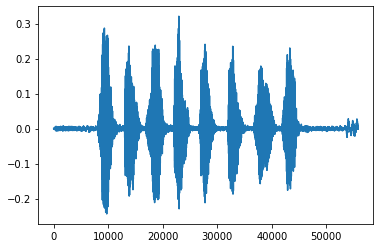

In [3]:
waveform = waveform[0,:].view(1,-1)

plt.plot(waveform.transpose(0,1).numpy())

In [4]:
import IPython.display as ipd

torchaudio.save("sound.wav", waveform, sample_rate)
ipd.Audio("sound.wav")

In [5]:
def compute_spectral_flatness(frame):
    EPSILON = 0.01
    n = frame.nonzero().size(0)
    geometric_mean = torch.exp((EPSILON + frame).log().mean(-1)) - EPSILON
    arithmetic_mean = frame.mean(-1)
    return -10 * torch.log10(EPSILON + geometric_mean/arithmetic_mean)

def compute_short_term_energy(frame):
    return frame.pow(2).sum(-1)

In [6]:
import math

# Parameters

frame_time = 10**-2

num_init_frames = 30
ignore_silent_count = 10
ignore_speech_count = 5

energy_prim_thresh = 40
frequency_prim_thresh = 5
spectral_flatness_prim_thresh = 3

# Determine number of frames and frame size

frame_size = int(math.ceil(sample_rate*frame_time))
waveform_length = waveform.size()[-1]
num_of_frames = math.floor(waveform_length/frame_size)

# Loop through frames

silent_count = 0
speech_frames = []

energy_list = []
frequency_list = []
spectral_flatness_list = []

for n in range(num_of_frames):
    frame = waveform[0, n*frame_size:(n+1)*frame_size].view(1,-1)
    frame_fft = torch.rfft(frame, 1)
    amplitudes = torchaudio.functional.complex_norm(frame_fft)

    # Compute frame energy
    energy = compute_short_term_energy(frame)
    
    # Most dominant frequency component
    frequency = amplitudes.argmax()
    
    # Spectral flatness measure
    spectral_flatness = compute_spectral_flatness(amplitudes)

    energy_list.append(energy)
    frequency_list.append(frequency)
    spectral_flatness_list.append(spectral_flatness)
    
    if n == 0:
        min_energy = energy
        min_frequency = frequency
        min_spectral_flatness = spectral_flatness
    elif n < num_init_frames:
        min_energy = min(energy, min_energy)
        min_frequency = min(frequency, min_frequency)
        min_spectral_flatness = min(spectral_flatness, min_spectral_flatness)
    
    thresh_energy = energy_prim_thresh * torch.log(min_energy)
    thresh_frequency = frequency_prim_thresh
    thresh_spectral_flatness = spectral_flatness_prim_thresh
    
    # Check all three conditions
    
    counter = 0
    if energy - min_energy >= thresh_energy:
        counter += 1
    if frequency - min_frequency >= thresh_frequency: 
        counter += 1
    if spectral_flatness - min_spectral_flatness >= thresh_spectral_flatness: 
        counter += 1
        
    # Detection
    
    if counter > 1:
        # Speech detected
        speech_frames.append(True)
        silent_count = 0
    else:
        # Silence detected
        speech_frames.append(False)
        
        min_energy = ((silent_count * min_energy) + energy) / (silent_count + 1)
        thresh_energy = energy_prim_thresh * torch.log(min_energy)
        silent_count += 1

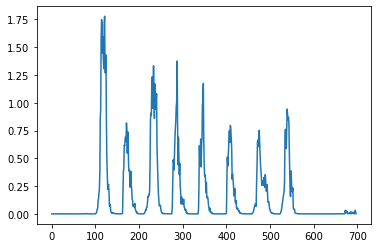

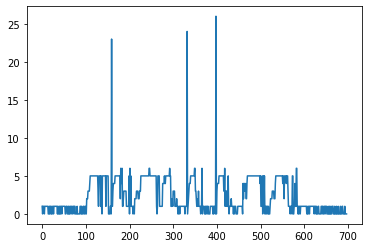

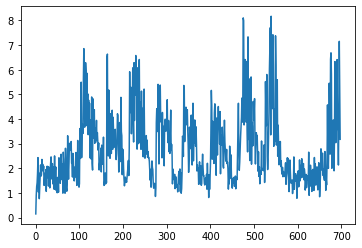

In [7]:
plt.figure()
plt.plot(energy_list)
plt.figure()
plt.plot(frequency_list)
plt.figure()
plt.plot(spectral_flatness_list)

In [8]:
import itertools

ignore_silent_count = 10
ignore_speech_count = 5


def find_changes_starting_with_false(x):
    if x[0]:
        return [0] + [i for i in range(1,len(x)) if x[i]!=x[i-1] ]
    else:
        return [i for i in range(1,len(x)) if x[i]!=x[i-1] ]


def ignore_too_short(x, start, count, lenght):
    
    i = start
    while i < len(x):
        
        if (i < 0) and (x[0] != 0) and (x[0] < count):
            x.pop(0)
            x.insert(0, 0)
            i += 1
        elif i < 0:
            i += 2
        elif i+1 > len(x) and length-x[i] < count:
            x.pop(i)
        elif i+1 < len(x) and x[i+1]-x[i] < count:
            x.pop(i)
            x.pop(i)
        else:
            i += 2


def reconstruct_speech_frame_from_delta(delta, length):
    z = [False]*length

    zipped = itertools.zip_longest(delta[0::2], delta[1::2], fillvalue=-1)

    for a,b in zipped:
        z[a:b] = [True]*(b-a)
    
    return z


def clean_frames(speech_frames):
    delta = find_changes_starting_with_false(speech_frames)
    
    # Ignore too short silence
    ignore_too_short(delta, -1, ignore_silent_count, len(speech_frames))
    # Ignore too short speech
    ignore_too_short(delta, 0, ignore_speech_count, len(speech_frames))
    
    return reconstruct_speech_frame_from_delta(delta, len(speech_frames))


speech_frames = clean_frames(speech_frames)

In [9]:
def reconstruct_waveform(speech_frames, waveform):
    z = torch.zeros(waveform.shape, dtype=waveform.dtype, device=waveform.device)

    n_frames = len(speech_frames)
    for i in range(n_frames):
        z[0, i*frame_size:(i+1)*frame_size] = int(speech_frames[i])
    
    # Extend with what was last detected
    z[0, n_frames*frame_size:-1] = int(speech_frames[-1])
    return z


z = reconstruct_waveform(speech_frames, waveform)

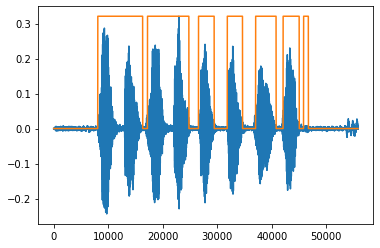

In [10]:
plt.plot(waveform[0,:].view(1,-1).t().numpy())
plt.plot(waveform.max().numpy()*z.t().numpy())